### TODO

- ~~Create the AdaIN layer~~
- ~~Create the reverse VGG19 model to have the decoder, and make it trainable~~
- ~~Create a custom model~~
- ~~Create the loss function~~
- ~~Automatically log the model and its hyperparameters on each training using MLFlow
--> Create a complete training pipeline : compile the model, fit it, log it (Add experiment and tags argument in the training function for the logging)~~
- ~~Create content and style datasets from the loaded images, with automatic image resizing pipeline for the training part (and eventually 256*256 window cropping)~~
- ~~Add getters and setters when required in AdaINDataModule (for train_val_test_split especially, maybe consider using the setattr method to handle all attributes at once)~~
- ~~Add verbose steps for the training process~~
- ~~Create the AdaINTrainer~~
- ~~Log the test loss in MLflow after training~~
- ~~Handle restart from checkpoint in AdaINTrainer~~
- Automatically clip the generated images to valid values

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import mlflow
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient
from sklearn.model_selection import train_test_split
from torchvision import transforms

os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras import Loss
from keras.preprocessing import image, image_dataset_from_directory # type: ignore
from pathlib import Path

from adain_model import AdaINModel, instance_mean, instance_std, AdaINLoss
from adain_datamodule import AdaINDataModule
from adain_trainer import AdaINTrainer

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-727.682..556.7332].


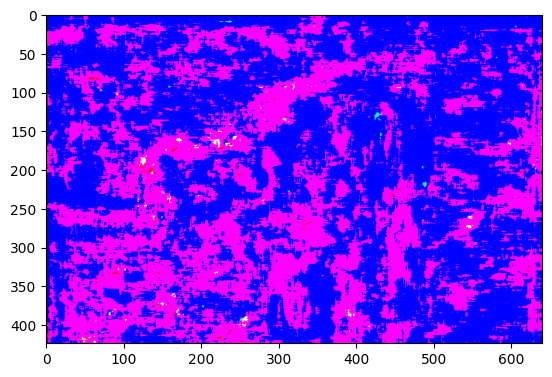

In [2]:
c = torch.tensor(np.array([keras.utils.img_to_array(image.load_img(Path("D:/StyleTransferAI/StyleTransferAI_AdaIN/datasets/unlabeled2017/unlabeled2017/000000000013.jpg")))]))#.permute(1,2,0).to('cuda')
s = torch.tensor(np.array([keras.utils.img_to_array(image.load_img(Path("D:/StyleTransferAI/StyleTransferAI_AdaIN/datasets/WikiArt/Abstract_Expressionism/alice-baber_abstract-composition-1969.jpg")))]))#.permute(1,2,0).to('cuda')
a = AdaINModel()
o = a([c,s])
plt.imshow(o.clone().detach().cpu().numpy()[0])

Initiating datasets...
Compiling the model...
Model is ready to be trained
Training the model...
0 / 1


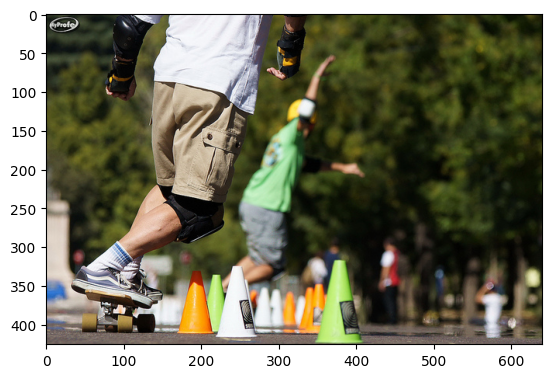

Epoch 1/3
0 / 1


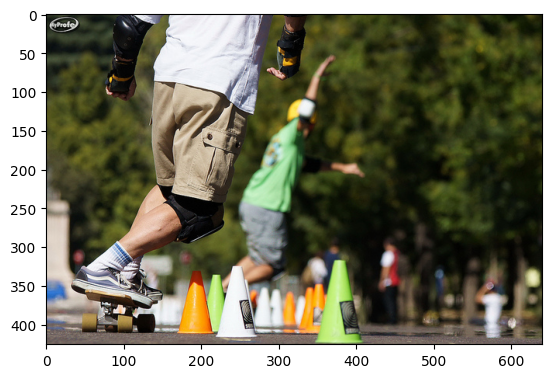

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 20383.60160 / 1


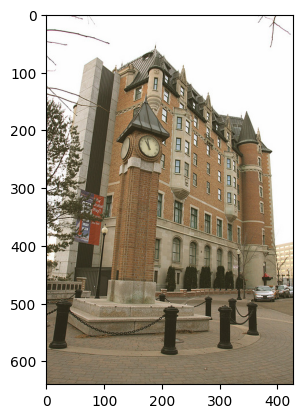

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - loss: 20383.6016 - val_loss: 148925.0469
Epoch 2/3
0 / 1


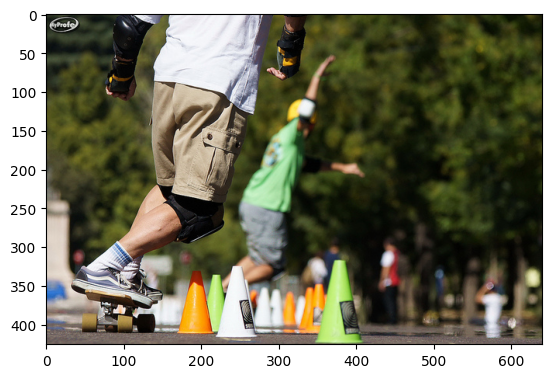

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 147755.78120 / 1


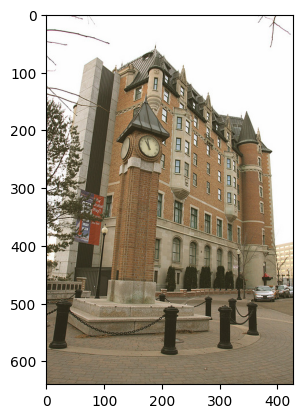

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - loss: 147755.7812 - val_loss: 12451.9688
Epoch 3/3
0 / 1


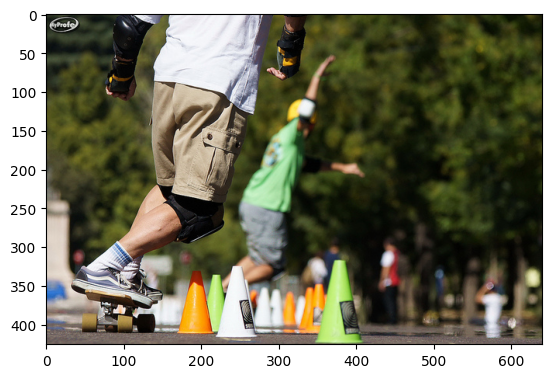

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 8489.98240 / 1


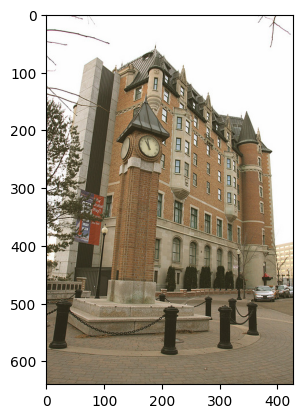

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - loss: 8489.9824 - val_loss: 8696.1035
0 / 1


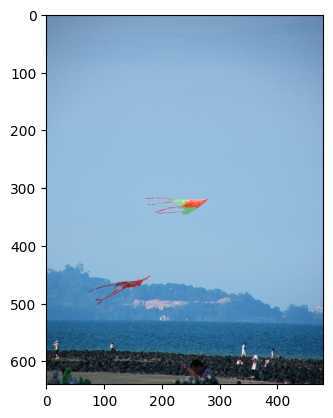

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 6296.9956
Checkpoint reached, model has been logged


Epoch 4/5
0 / 1


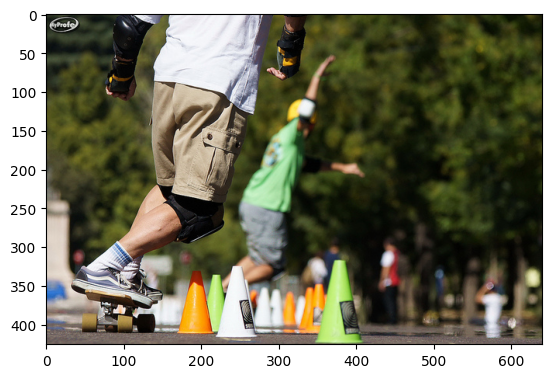

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 4563.09180 / 1


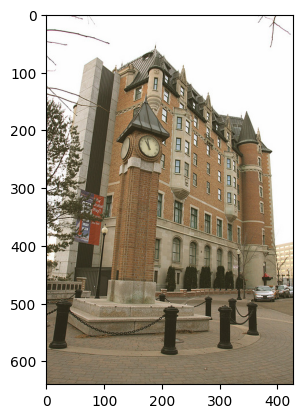

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - loss: 4563.0918 - val_loss: 12427.5352
Epoch 5/5
0 / 1


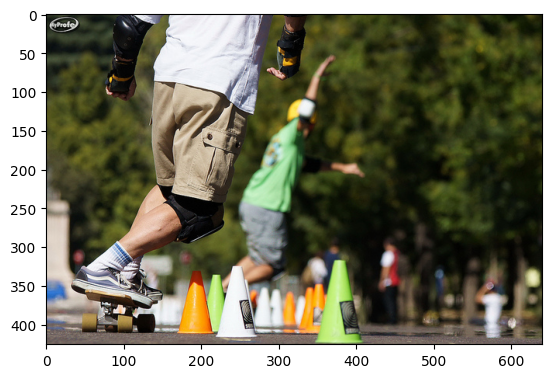

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 9534.90230 / 1


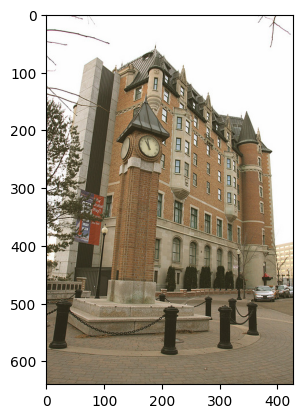

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - loss: 9534.9023 - val_loss: 9908.5986
0 / 1


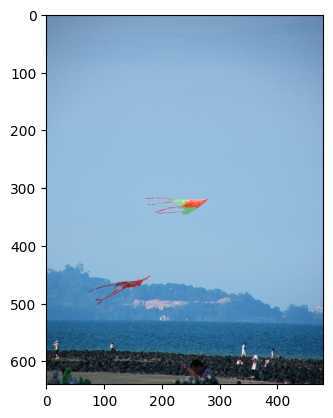

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 8999.4053
Checkpoint reached, model has been logged
The training is complete ! The model and its performances have been logged in MLFlow


In [8]:
dm = AdaINDataModule(Path("D:/StyleTransferAI/StyleTransferAI_AdaIN/datasets/unlabeled2017/"), Path("D:/StyleTransferAI/StyleTransferAI_AdaIN/datasets/WikiArt/"), dataset_size=3, seed=444, batch_size=1, train_val_test_split=(0.333,0.333,0.333))
model = AdaINModel(lamb=0.75)

trainer = AdaINTrainer(model, dm, 'adam', mlflow_dir=Path("D:/Python/ML Flow/mlruns"), mlflow_tags={"Dataset size" : 10000})
trainer.train(epochs=5, steps_per_epoch=1, log_every_n_epochs=3, validation_steps=1, test_steps=1)

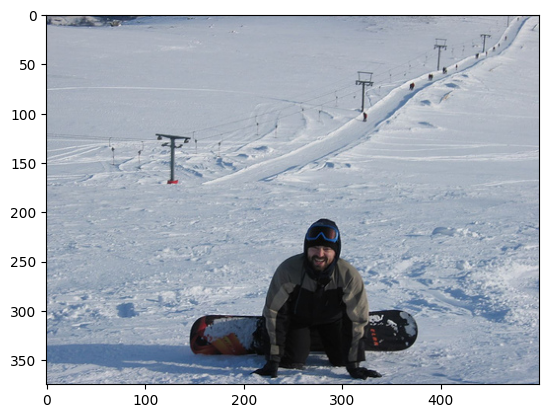

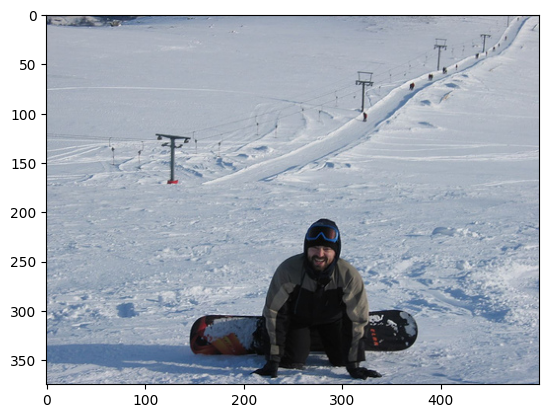

In [4]:
content = dm._test_dataset[500][0][0].unsqueeze(0)
style = dm._test_dataset[500][0][1].unsqueeze(0)

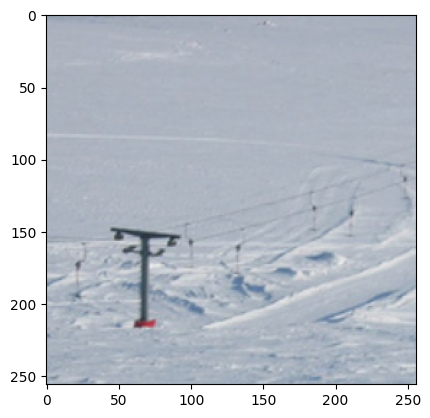

In [5]:
plt.imshow(content[0].clone().detach().cpu().numpy())

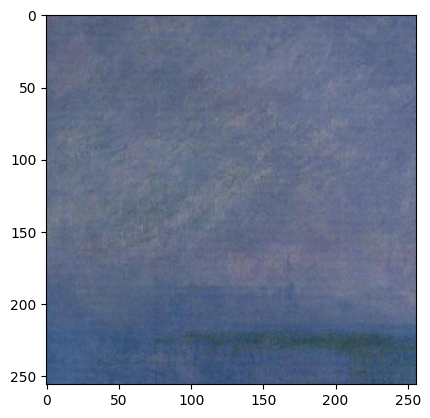

In [6]:
plt.imshow(style[0].clone().detach().cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1478088..-0.07557852].


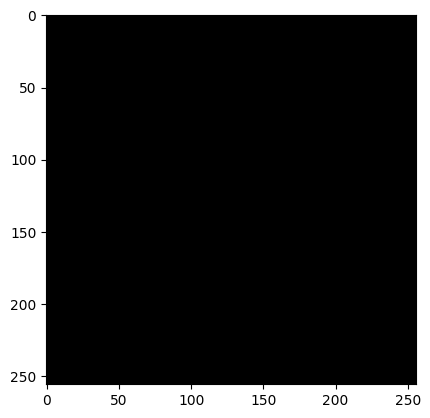

In [7]:
plt.imshow(model([content,style]).clone().detach().cpu().numpy()[0])